Code here based on https://choishingwan.github.io/PRS-Tutorial/plink_visual/

Main R notebook referred throughout is : `GenSpace-Pgx_day2.ipynb`

Which PRS tranche fit the best based on Nagelkerke's R<sup>2</sup>?

Load package needed for calculating Nagelkerke's

In [3]:
library(fmsb)

Load dataset and merge with PCs (computer in main notebook)

In [4]:
dataset <- read.table("OUTCOME/MDD.pe2.profile",header=T)
# Read the PC file into a file called 'pca'
pca <- read.table("OUTCOME/PCA_20_for_1000_Genomes.eigenvec")

# Provide the column names with this command.
names(pca) <- c("FID","IID",paste0("PC",1:20))

# Merge the polygenic score file (dataset) and the pca file (pca). Merging will be based on the "FID" and "IID" columns.
dataset <- merge(dataset,pca,by=c("FID","IID"))

Run null / reduced model with no PRS for computing Nagelkerke's R<sup>2</sup>

In [5]:
null.model <- glm(data=dataset, PHENO-1 ~ PC1 + PC2 + PC3 + PC4 + PC5 +
                      PC6 + PC7 + PC8 + PC9 + PC10, family = "binomial")

# And the R2 of the null model is 
null.r2 <- NagelkerkeR2(null.model)[[2]]

Load files with different p-value tranches that have been precomputed in the main R notebook, spits out all the R<sup>2</sup> values from each tranche, and prints out the best fitting p-value tranche

In [7]:
p.threshold <- c('Psi','Pe6','pe4','pe3','pe2','P05','P10','P20','P30','P40','P50','P75','all')

prs.result <- NULL

for(i in p.threshold){
    # Go through each p-value threshold
    prs <- read.table(paste0("OUTCOME/MDD.", i, ".profile"),header=T)
    # Merge the prs with the phenotype matrix
    # We only want the FID, IID and PRS from the PRS file, therefore we only select the 
    # relevant columns
    prs <- merge(prs, pca, by=c("FID","IID"))    
    # Now perform a linear regression on Height with PRS and the covariates
    # ignoring the FID and IID from our model
    model <- glm(data=prs, PHENO-1 ~ SCORE + PC1 + PC2 + PC3 + PC4 + PC5 +
                   PC6 + PC7 + PC8 + PC9 + PC10, family = "binomial")    # model R2 is obtained as 
    model.r2 <- NagelkerkeR2(model)[[2]]
    print(model.r2)
    # R2 of PRS is simply calculated as the model R2 minus the null R2
    prs.r2 <- model.r2-null.r2
    # We can also obtain the coeffcient and p-value of association of PRS as follow
    prs.coef <- summary(model)$coeff["SCORE",]
    prs.beta <- as.numeric(prs.coef[1])
    prs.se <- as.numeric(prs.coef[2])
    prs.p <- as.numeric(prs.coef[4])
    # We can then store the results
    prs.result <- rbind(prs.result, data.frame(Threshold=i, R2=prs.r2, P=prs.p, BETA=prs.beta,SE=prs.se))
}
# Best result is:
prs.result[which.max(prs.result$R2),]

[1] 0.004788561
[1] 0.004991569
[1] 0.005259243
[1] 0.004804473
[1] 0.004711286
[1] 0.00480316
[1] 0.004808537
[1] 0.004755491
[1] 0.004788515
[1] 0.004892784
[1] 0.00491477
[1] 0.004814941
[1] 0.004825364


,Threshold,R2,P,BETA,SE
3,pe4,0.0006608633,0.2645591,80.02021,71.72326


Print out the PRS fits with better views

In [10]:
prs.result

Threshold,R2,P,BETA,SE
Psi,0.0001901815,0.5494565,-8.608296,14.38132
Pe6,0.0003931894,0.3894709,-21.972412,25.53218
pe4,0.0006608633,0.2645591,80.020214,71.72326
pe3,0.0002060930,0.5332144,-82.953107,133.12825
pe2,0.0001129060,0.6446379,-125.622720,272.36809
P05,0.0002047804,0.5345143,-297.146519,478.39685
P10,0.0002101577,0.5292007,-384.160315,610.52771
P20,0.0001571113,0.5864011,-443.271269,814.74906
P30,0.0001901351,0.5495062,-580.010621,969.10669
P40,0.0002944045,0.4564489,-811.907399,1090.23757


Visualizing `prs.result` object

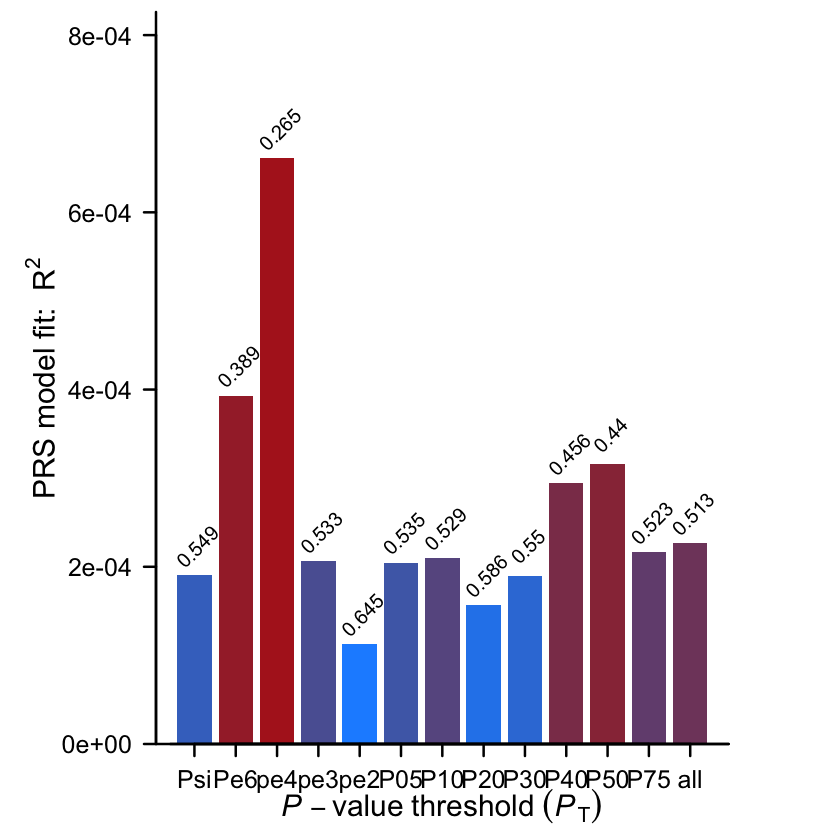

In [12]:
col <- suppressWarnings(colorRampPalette(c("dodgerblue", "firebrick")))
# We want the color gradient to match the ranking of p-values
prs.result <- prs.result[order(-log10(prs.result$P)),]
prs.result$color <-  col(nrow(prs.result))
prs.result <- prs.result[order(prs.result$Threshold),]
# generate a pretty format for p-value output
prs.result$print.p <- round(prs.result$P, digits = 3)
prs.result$print.p[!is.na(prs.result$print.p) & prs.result$print.p == 0 ] <-
    format(prs.result$P[!is.na(prs.result$print.p) & prs.result$print.p == 0 ], digits = 2)
prs.result$print.p <- sub("e", "*x*10^", prs.result$print.p)
# Generate the axis labels
xlab <- expression(italic(P) - value ~ threshold ~ (italic(P)[T]))
ylab <- expression(paste("PRS model fit:  ", R ^ 2))
# Setup the drawing area
layout(t(1:2), widths=c(8.8,1.2))
par( cex.lab=1.5, cex.axis=1.25, font.lab=2, 
    oma=c(0,0.5,0,0),
    mar=c(4,6,0.5,0.5))
# Plotting the bars
b<- barplot(height=prs.result$R2, 
            col=prs.result$color, 
            border=NA, 
            ylim=c(0, max(prs.result$R2)*1.25), 
            axes = F, ann=F)
# Plot the axis labels and axis ticks
odd <- seq(0,nrow(prs.result)+1,2)
even <- seq(1,nrow(prs.result),2)
axis(side=1, at=b[odd], labels=prs.result$Threshold[odd], lwd=2)
axis(side=1, at=b[even], labels=prs.result$Threshold[even],lwd=2)
axis(side=1, at=c(0,b[1],2*b[length(b)]-b[length(b)-1]), labels=c("","",""), lwd=2, lwd.tick=0)
# Write the p-value on top of each bar
text( parse(text=paste(
    prs.result$print.p)), 
    x = b+0.1, 
    y =  prs.result$R2+ (max(prs.result$R2)*1.05-max(prs.result$R2)), 
    srt = 45)
# Now plot the axis lines
box(bty='L', lwd=2)
axis(2,las=2, lwd=2)
# Plot the axis titles
title(ylab=ylab, line=4, cex.lab=1.5, font=2 )
title(xlab=xlab, line=2.5, cex.lab=1.5, font=2 )